In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
pd.options.display.max_columns = None
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
df = pd.read_parquet('../../data_parquet/energy.parquet')
df_copy = df.copy()

In [3]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   id                                           35064 non-null  int64         
 1   time_hourly                                  35064 non-null  datetime64[ns]
 2   generation_biomass                           35064 non-null  int64         
 3   generation_fossil_brown_coal_lignite         35064 non-null  int64         
 4   generation_fossil_coal_derived_gas           35064 non-null  int64         
 5   generation_fossil_gas                        35064 non-null  int64         
 6   generation_fossil_hard_coal                  35064 non-null  int64         
 7   generation_fossil_oil                        35064 non-null  int64         
 8   generation_fossil_oil_shale                  35064 non-null  int64         


**Limpieza**

In [4]:
# Revisión nulos (aunque en la fase de etl ya se revisó y corrigió)
df_copy.isna().sum()

id                                             0
time_hourly                                    0
generation_biomass                             0
generation_fossil_brown_coal_lignite           0
generation_fossil_coal_derived_gas             0
generation_fossil_gas                          0
generation_fossil_hard_coal                    0
generation_fossil_oil                          0
generation_fossil_oil_shale                    0
generation_fossil_peat                         0
generation_geothermal                          0
generation_hydro_pumped_storage_consumption    0
generation_hydro_run_of_river_and_poundage     0
generation_hydro_water_reservoir               0
generation_marine                              0
generation_nuclear                             0
generation_other                               0
generation_other_renewable                     0
generation_solar                               0
generation_waste                               0
generation_wind_offs

In [5]:
df_copy.duplicated().sum() # Revisión duplicados

0

In [11]:
df_copy.describe().drop(['time_hourly', 'id'], axis=1)

generation_biomass  generation_fossil_brown_coal_lignite  \
count        35064.000000                          35064.000000   
mean           383.305727                            447.829198   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   
std             85.796305                            354.622834   

       generation_fossil_coal_derived_gas  generation_fossil_gas  \
count                             35064.0           35064.000000   
mean                                  0.0            5619.851072   
min                                   0.0               0.000000   
25%                                   0.0            4125.000000   
50%                                   0.0            4968.000000   
75%                                   0.0            6428.000000   
max                                   0.0           20034.000000   
std                                   0.0            2204.946787   

       generation_fossil_hard_coal  generation_fossil_oil  \
count                 35064.000000           35064.000000   
mean                   4253.880903             298.158139   
min                       0.000000               0.000000   
25%                    2524.750000             263.000000   
50%                    4473.000000             300.000000   
75%                    5837.000000             330.000000   
max                    8359.000000             449.000000   
std                    1963.465684              52.963429   

       generation_fossil_oil_shale  generation_fossil_peat  \
count                      35064.0                 35064.0   
mean                           0.0                     0.0   
min                            0.0                     0.0   
25%                            0.0                     0.0   
50%                            0.0                     0.0   
75%                            0.0                     0.0   
max                            0.0                     0.0   
std                            0.0                     0.0   

       generation_geothermal  generation_hydro_pumped_storage_consumption  \
count                35064.0                                 35064.000000   
mean                     0.0                                   475.319644   
min                      0.0                                     0.000000   
25%                      0.0                                     0.000000   
50%                      0.0                                    67.000000   
75%                      0.0                                   615.000000   
max                      0.0                                  4523.000000   
std                      0.0                                   792.269198   

       generation_hydro_run_of_river_and_poundage  \
count                                35064.000000   
mean                                   971.589351   
min                                      0.000000   
25%                                    637.000000   
50%                                    905.000000   
75%                                   1250.000000   
max                                   2000.000000   
std                                    401.307115   

       generation_hydro_water_reservoir  generation_marine  \
count                      35064.000000            35064.0   
mean                        2603.777407                0.0   
min                            0.000000                0.0   
25%                         1076.000000                0.0   
50%                         2163.000000                0.0   
75%                         3756.250000                0.0   
max                         9728.000000                0.0   
std          

**Distribuciónes**

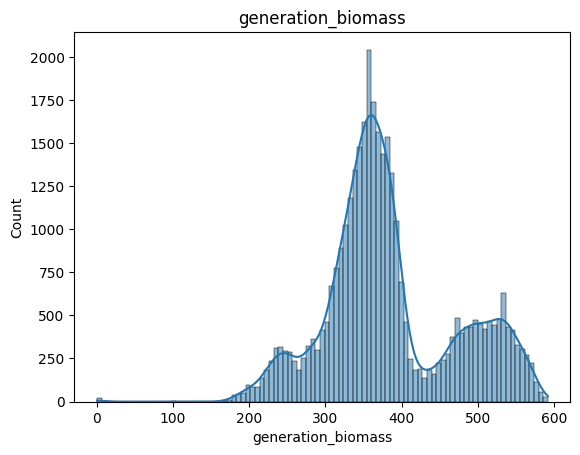

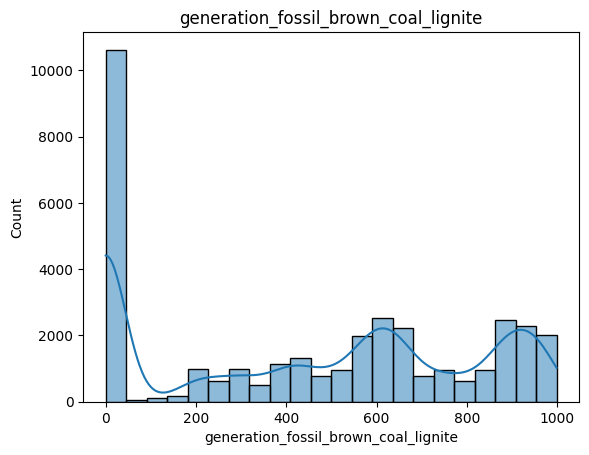

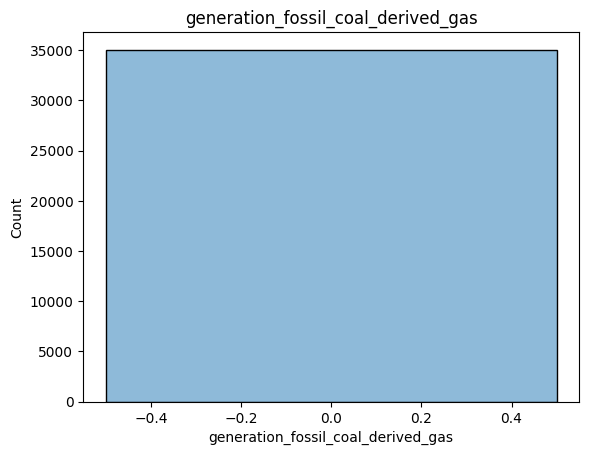

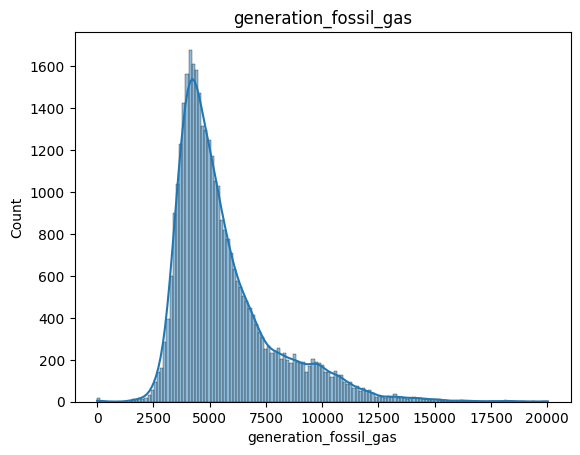

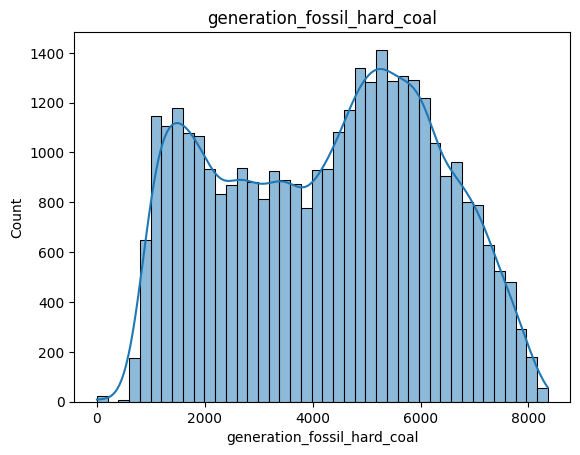

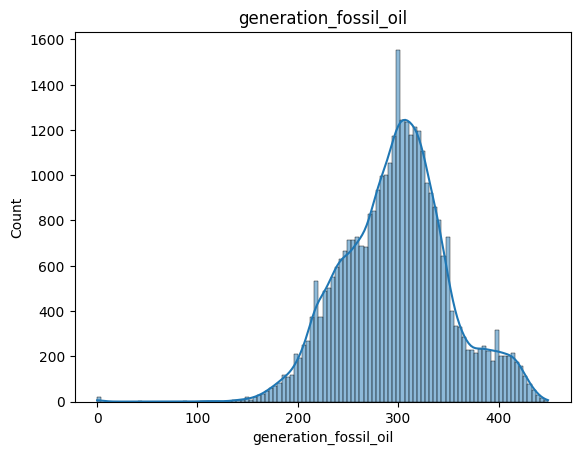

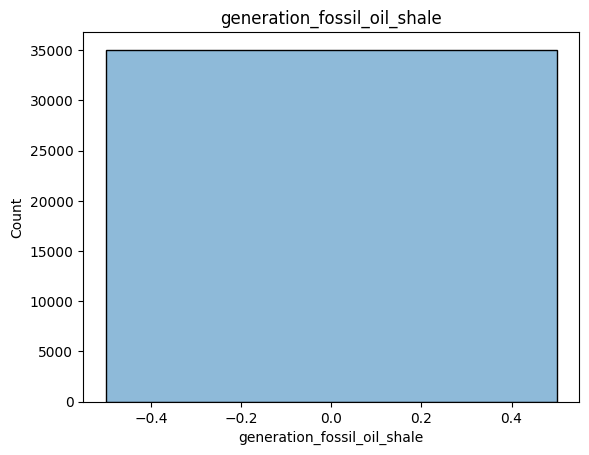

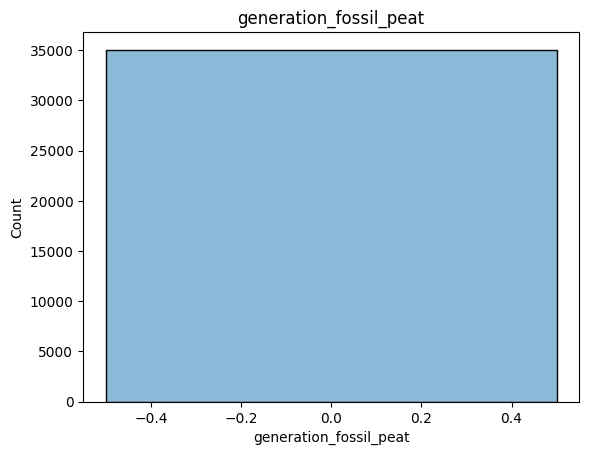

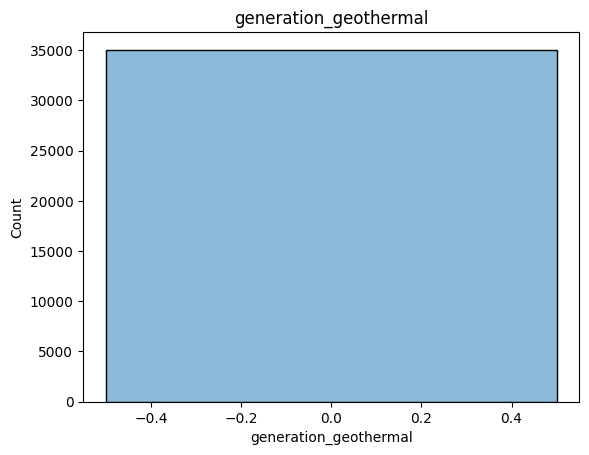

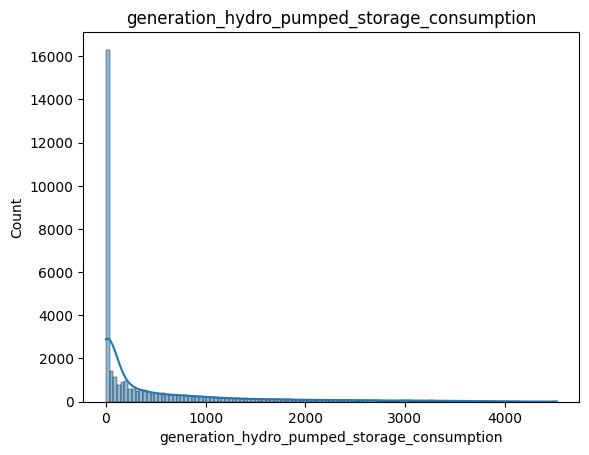

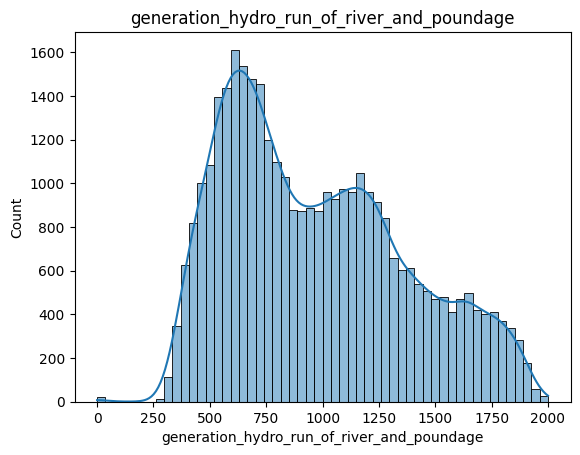

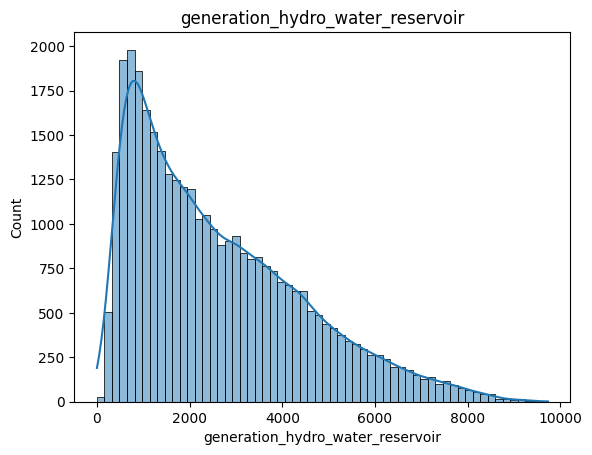

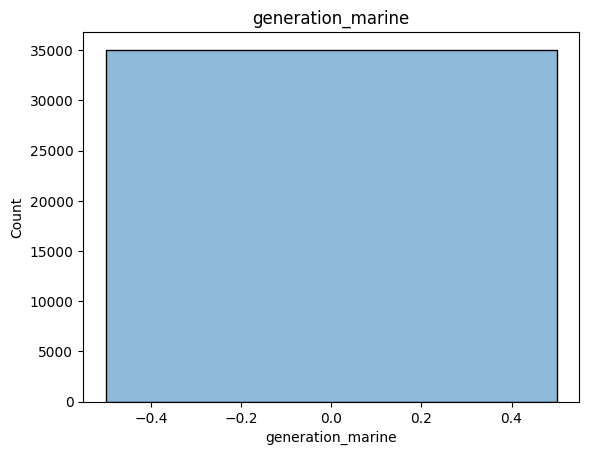

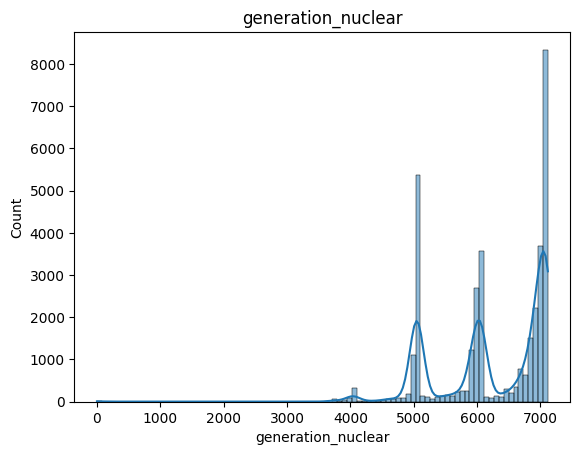

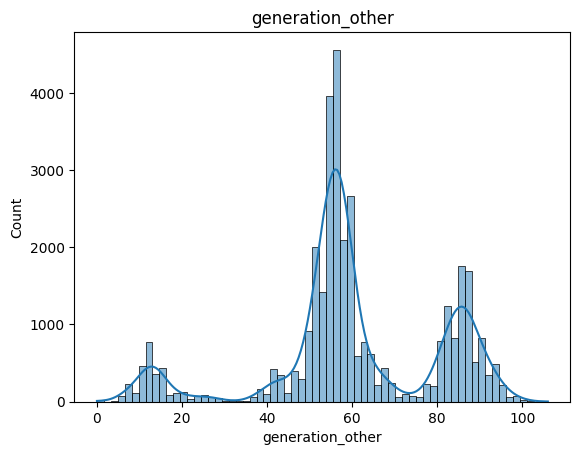

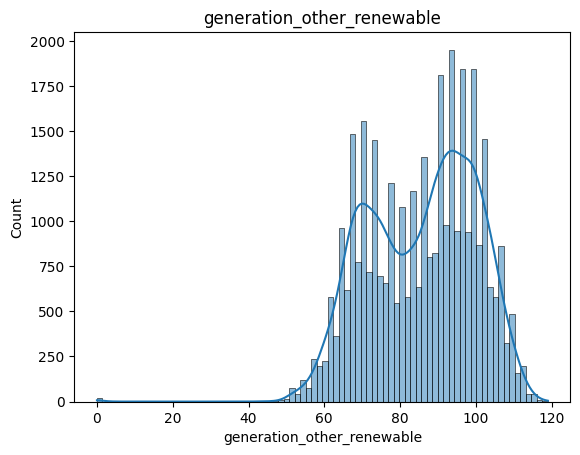

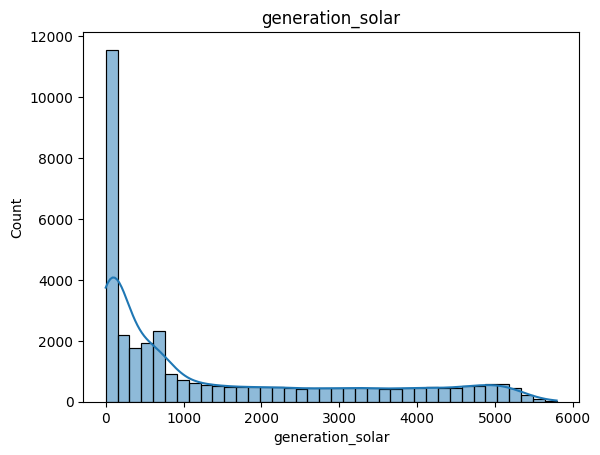

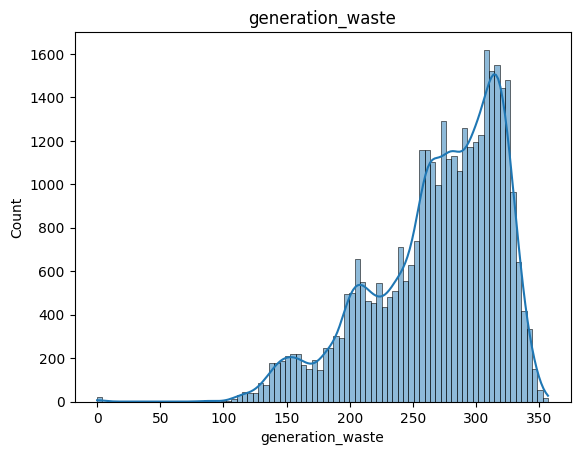

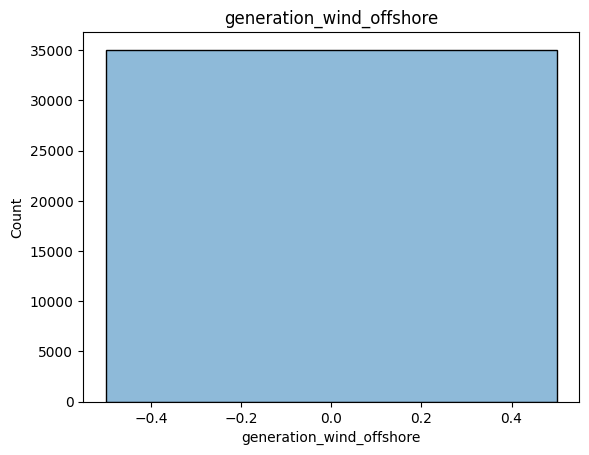

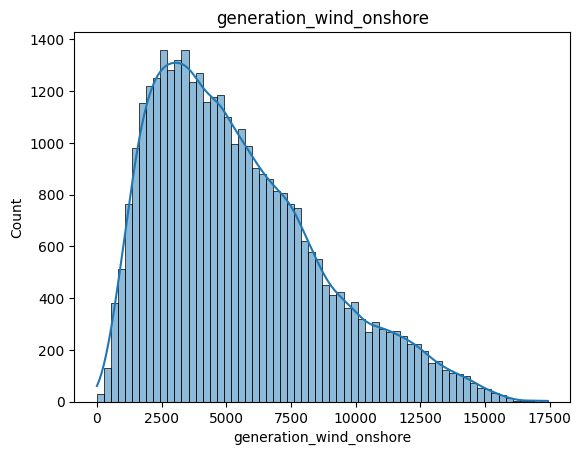

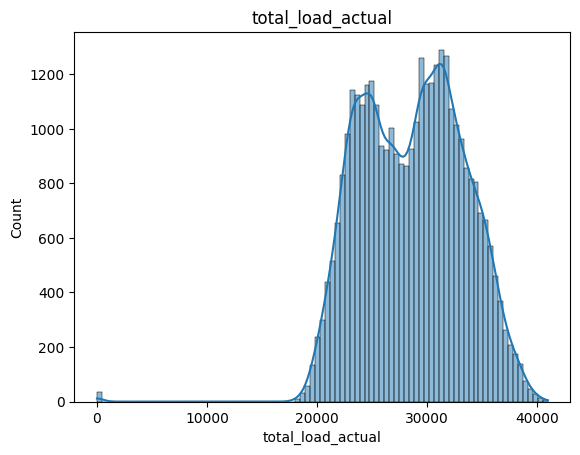

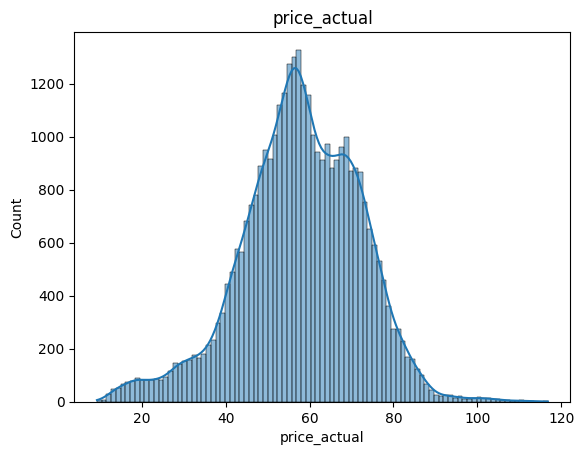

In [18]:
hist_columns = df_copy.drop(['time_hourly', 'id'], axis=1)
for col in hist_columns.columns:
    sns.histplot(data=hist_columns, x=col, kde=True)
    plt.title(col)
    plt.show()


Eliminamos variables: generation_fossil_coal_derived_gas, generation_fossil_oil_shale, generation_fossil_peat, generation_geothermal,
generation_marine, generation_wind_offshore.

Presentan valores 0 en todos los registros.

In [3]:
drop_columns = ['generation_fossil_coal_derived_gas','generation_fossil_oil_shale',
                'generation_fossil_peat', 'generation_geothermal', 'generation_marine','generation_wind_offshore']
df_copy.drop(drop_columns, axis=1, inplace=True)

**Correlaciones**

<Axes: >

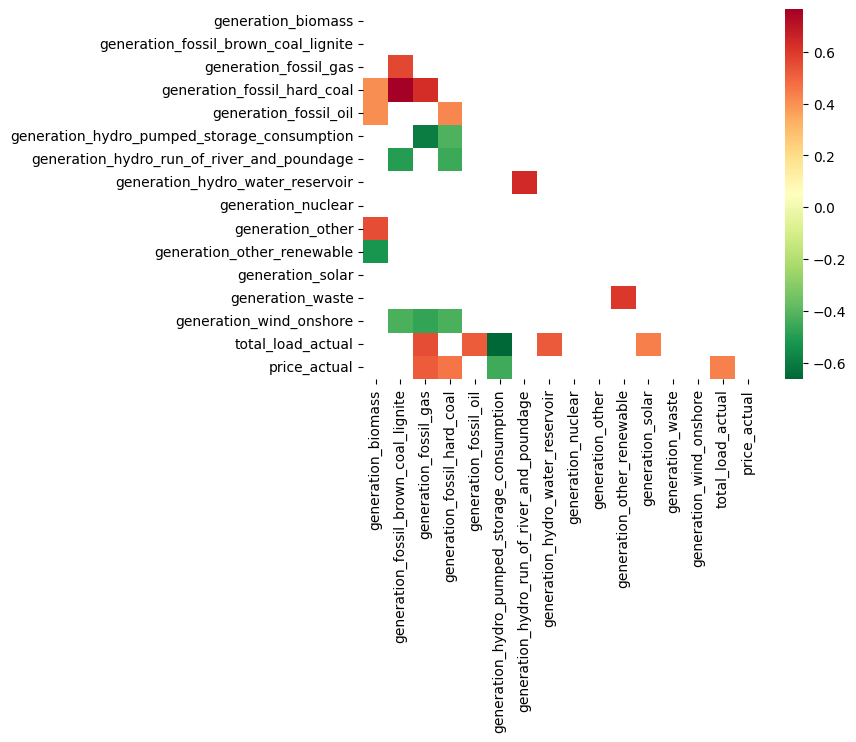

In [4]:
# Correlacion entre características
columns = df_copy.drop(['time_hourly', 'id'], axis=1).corr('spearman')
mask = np.triu(np.ones_like(columns, dtype=bool)) | ((np.abs(columns) <= 0.4) & (np.abs(columns) >= -0.4))
sns.heatmap(columns, mask=mask, cmap='RdYlGn_r', annot=False)

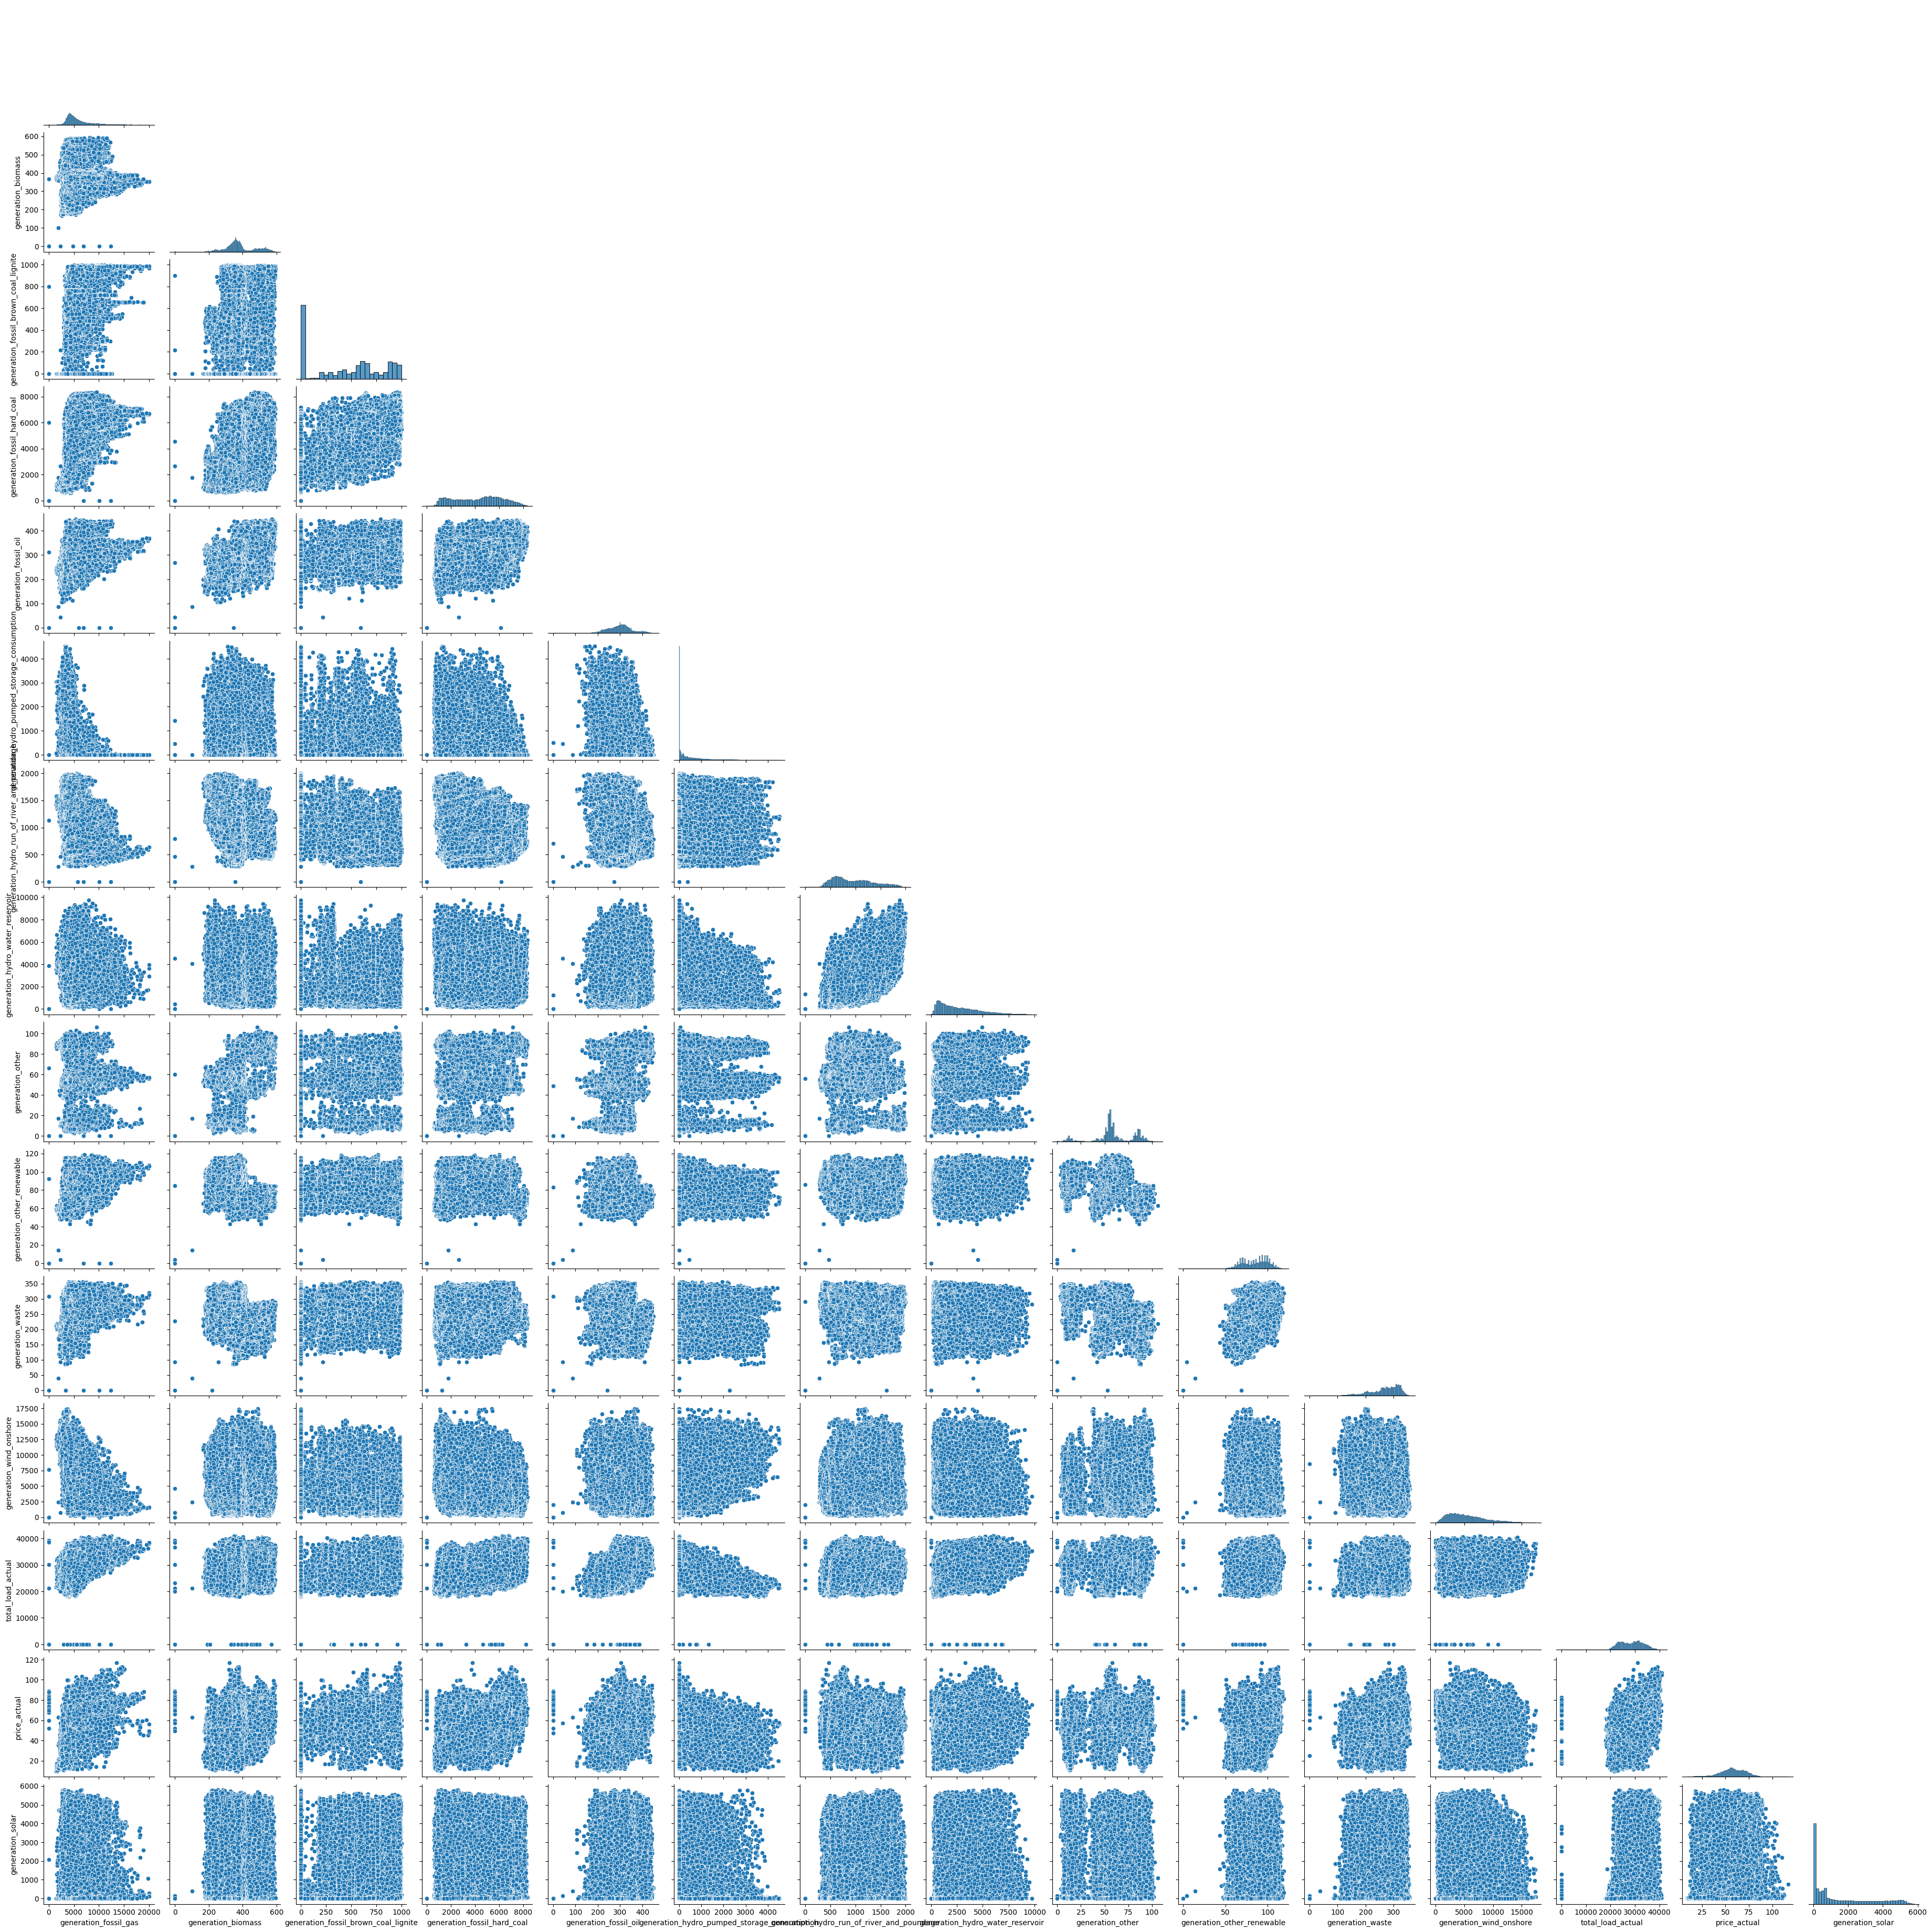

In [5]:
# gráfico de dispersión sobre correlaciones mas fuertes.
columns_pairplot= ['generation_fossil_gas','generation_biomass','generation_fossil_brown_coal_lignite',
                   'generation_fossil_hard_coal','generation_fossil_oil',
                   'generation_hydro_pumped_storage_consumption','generation_hydro_run_of_river_and_poundage',
                   'generation_hydro_water_reservoir','generation_other','generation_other_renewable',
                   'generation_waste','generation_wind_onshore','total_load_actual','price_actual', 'generation_solar']
pair_plot = df_copy[columns_pairplot]

sns.pairplot(pair_plot, corner=True)

**Análisis por grupos**

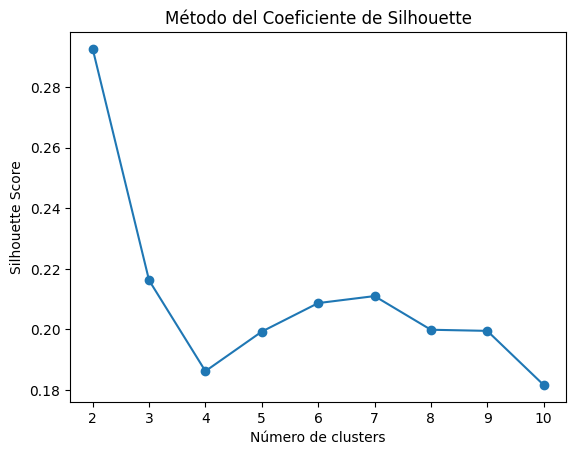

In [4]:
# Método de silhouette (Observamos cuantos clusteres necesitaremos)
x_kmeans = df_copy.drop(['time_hourly', 'id', 'total_load_actual','price_actual'], axis=1)
silhouette_scores = []
range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_kmeans)
    silhouette_avg = silhouette_score(x_kmeans, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Método del Coeficiente de Silhouette")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [5]:
# Extraer los clusteres
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(x_kmeans)

In [7]:
x_kmeans['Cluster'] = y_kmeans
counter = x_kmeans['Cluster'].value_counts()

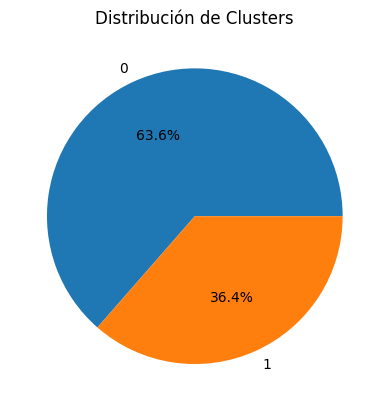

In [65]:
plt.pie(counter, labels = counter.index, autopct='%1.1f%%')
plt.title('Distribución de Clusters')
plt.show()

In [46]:
# Reducción de dimensionalidad a 2 dimensiones
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(x_kmeans.drop('Cluster', axis = 1))

In [47]:
pca_df = pd.DataFrame(data = X_reduced, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = x_kmeans['Cluster']

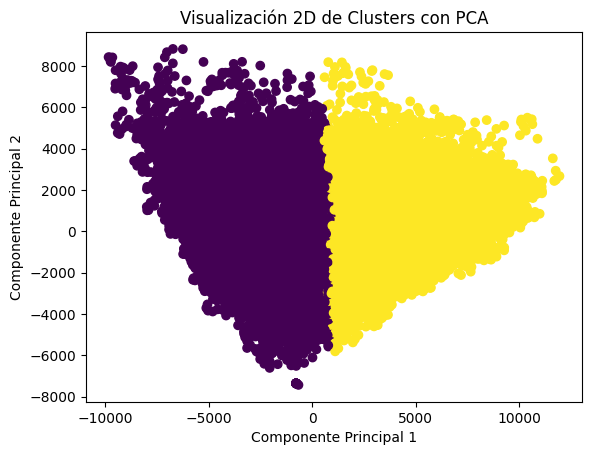

In [48]:
# Gráfico en 2D según clusteres
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'])

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

plt.title('Visualización 2D de Clusters con PCA')
plt.show()

In [49]:
# Características en funcion de cada cluster (Observamos la representatividad de cada columna en funcion de los grupos)
centroids = x_kmeans.groupby('Cluster').mean()

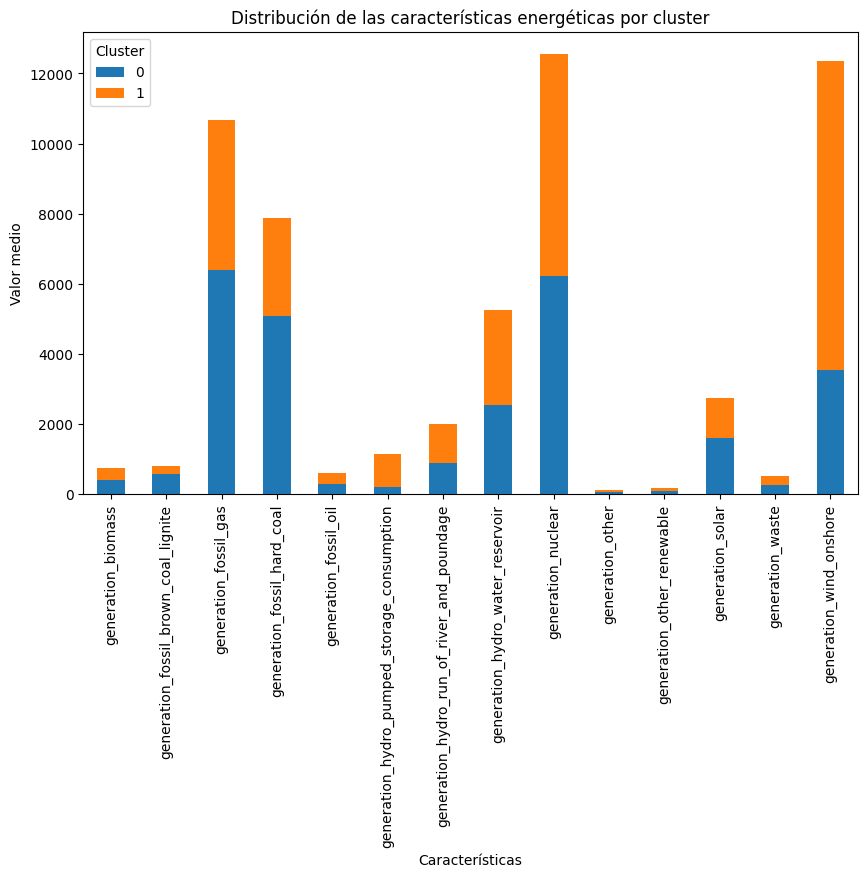

In [50]:
centroids.transpose().plot(kind='bar', stacked=True, figsize=(10,6))

plt.title('Distribución de las características energéticas por cluster')
plt.xlabel('Características')
plt.ylabel('Valor medio')
plt.show()

In [51]:
centroids_c0 = x_kmeans[x_kmeans['Cluster']==0].mean().sort_values(ascending=False)
centroids_c1 = x_kmeans[x_kmeans['Cluster']==1].mean().sort_values(ascending=False)

In [52]:
df_clusters = pd.DataFrame({
    'cluster_0':centroids_c0,
    'cluster_1':centroids_c1
})

In [53]:
df_clusters.sort_values(by=['cluster_0','cluster_1'],ascending=False, inplace=True)

In [67]:
# Seleccionar las seis características más importantes para cada clúster
top_features_0 = df_clusters['cluster_0'].nlargest(5)
top_features_1 = df_clusters['cluster_1'].nlargest(5)

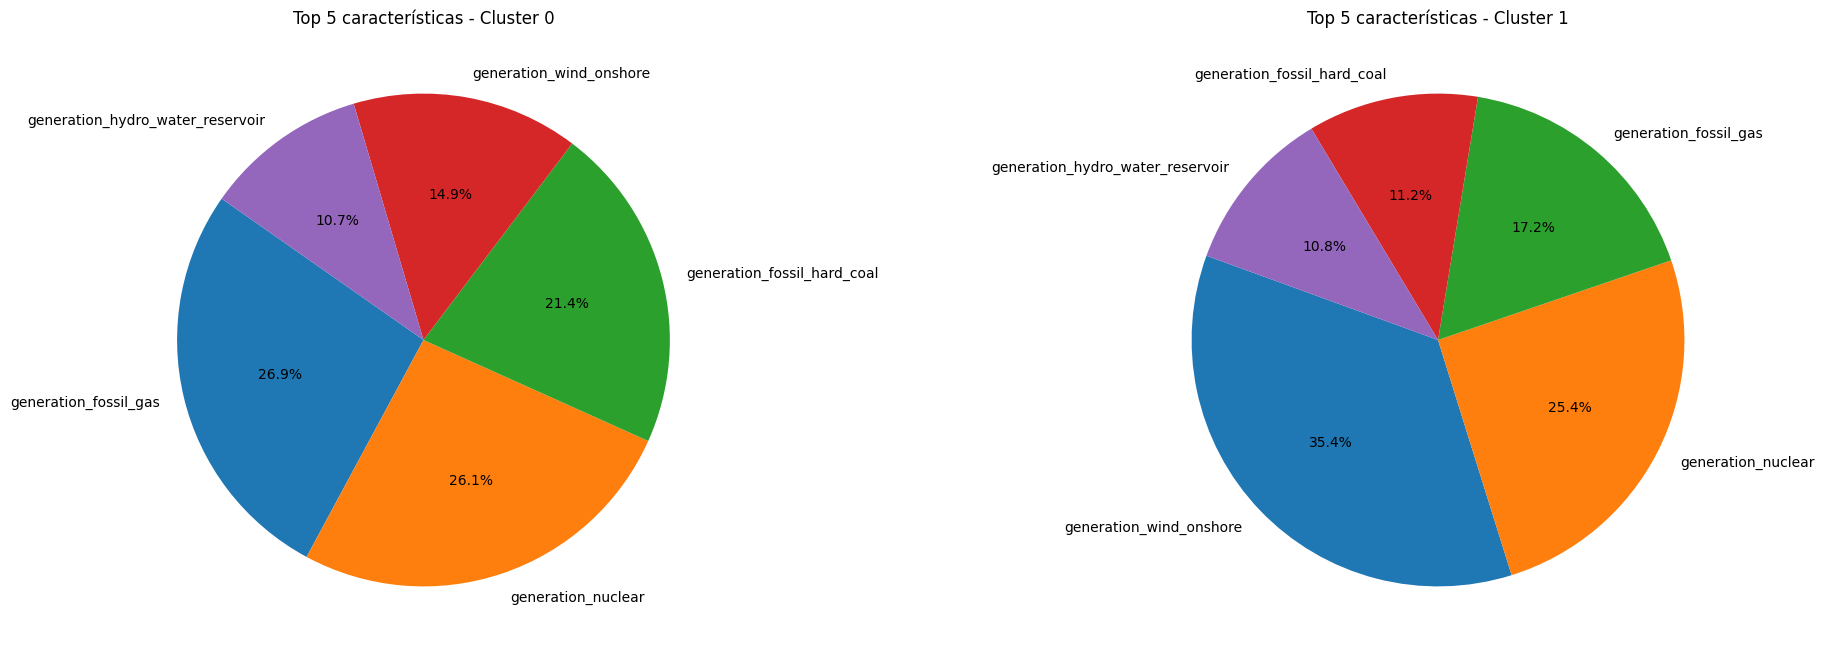

In [68]:
# Crear gráficos circulares para cada clúster
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

axs[0].pie(top_features_0, labels=top_features_0.index, autopct='%1.1f%%', startangle=145)
axs[0].set_title('Top 5 características - Cluster 0')

axs[1].pie(top_features_1, labels=top_features_1.index, autopct='%1.1f%%', startangle=160)
axs[1].set_title('Top 5 características - Cluster 1')

plt.show()

Podemos identificar estos tres clusteres como:

- Cluster 0: Predominancia de Energías Fósiles y Nuclear.
- Cluster 1: Predominancia de Energías Renovables y Nuclear.

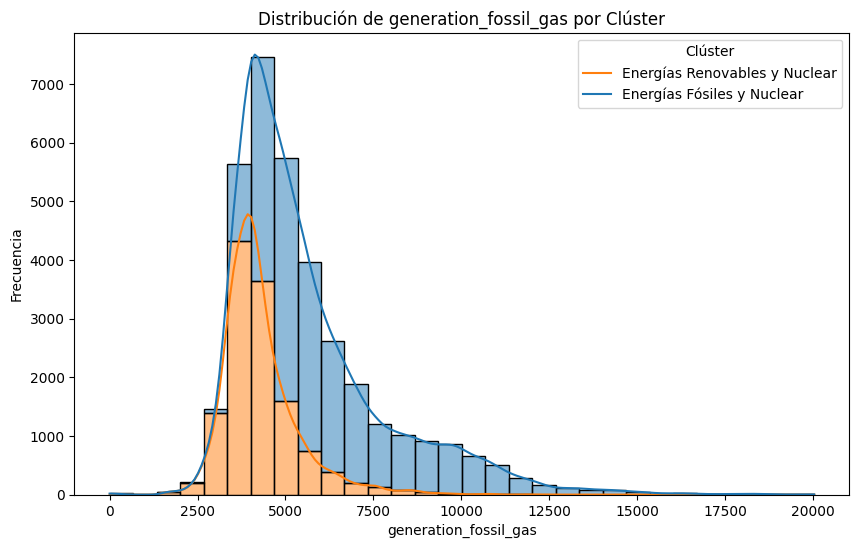

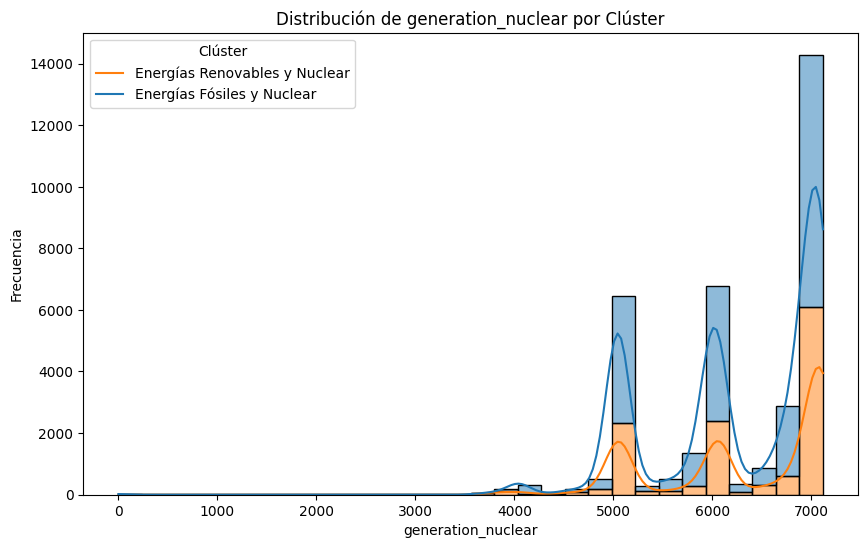

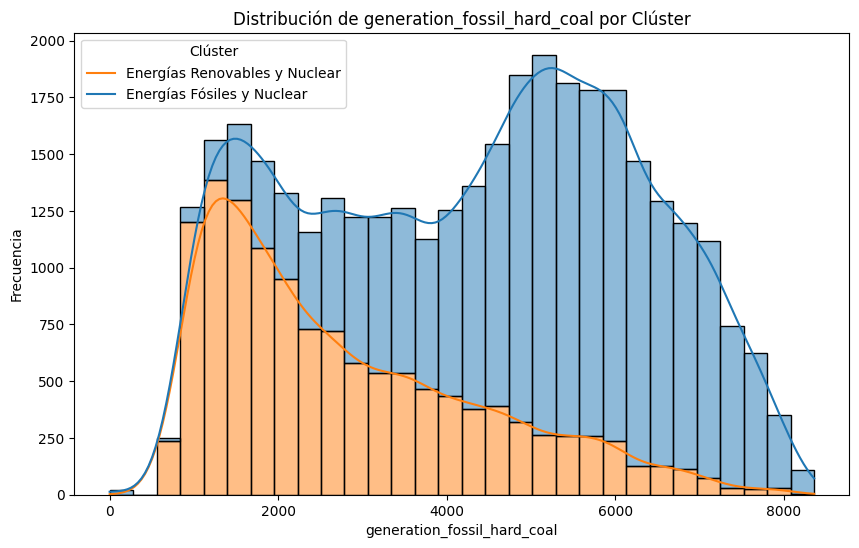

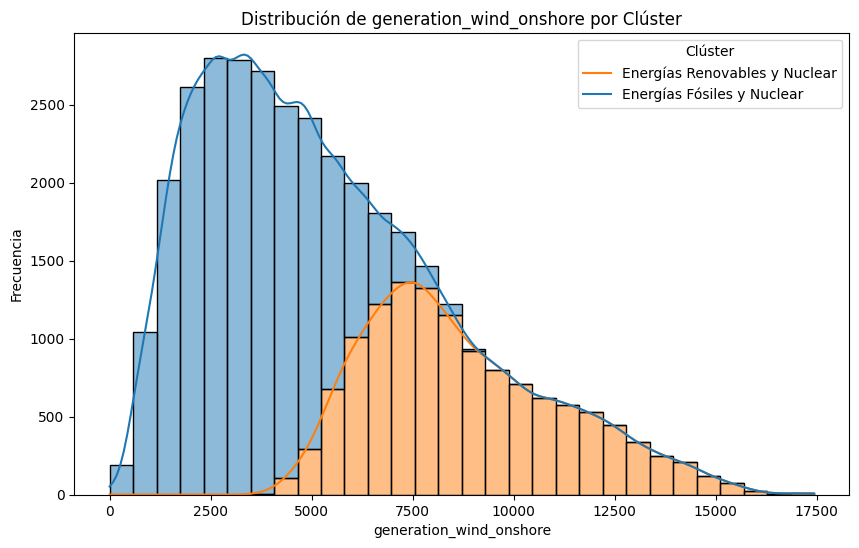

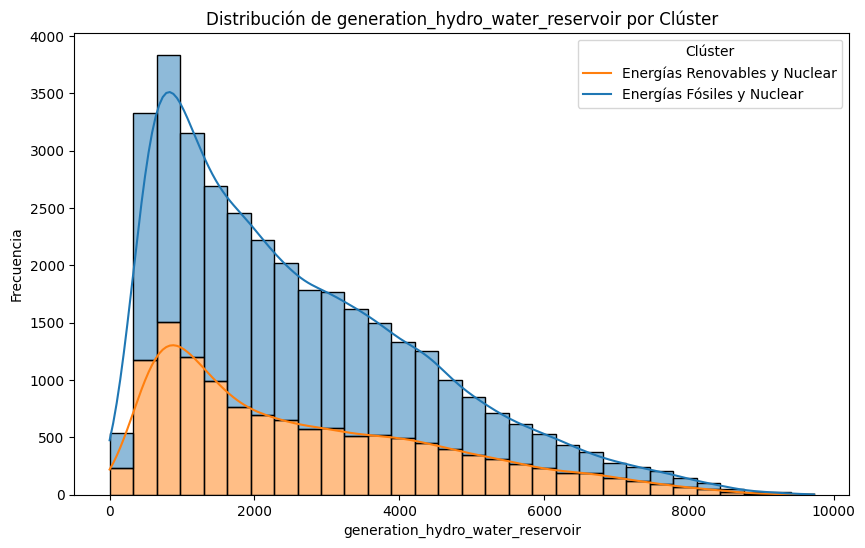

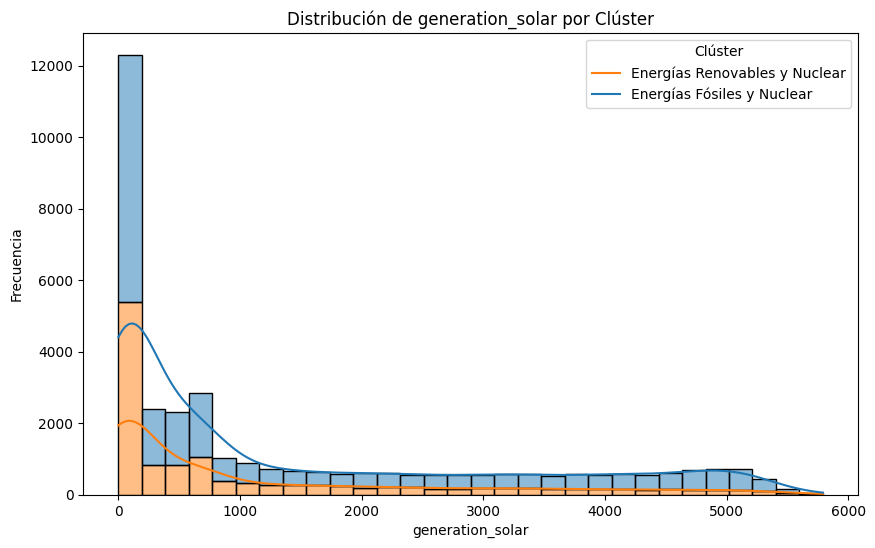

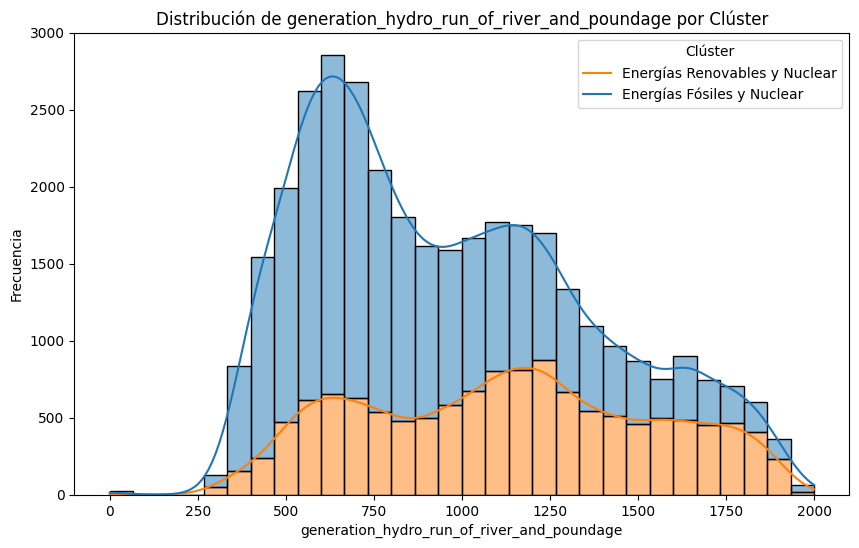

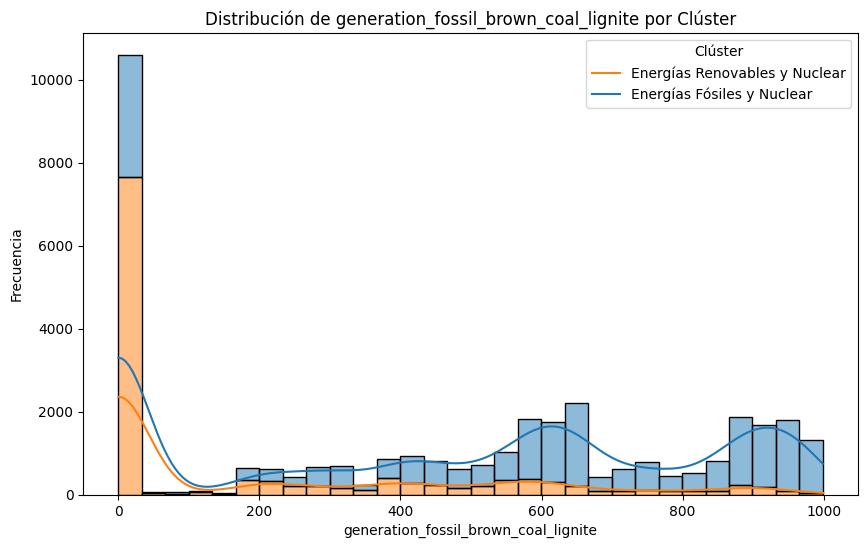

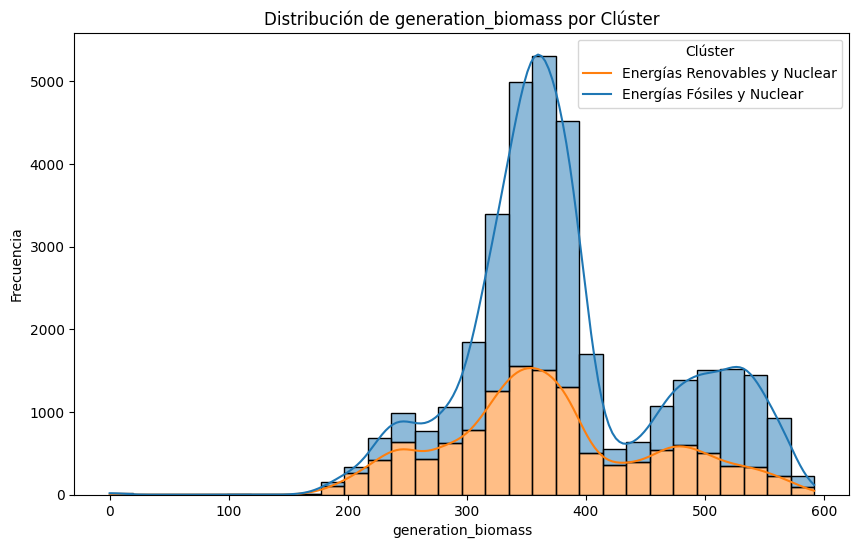

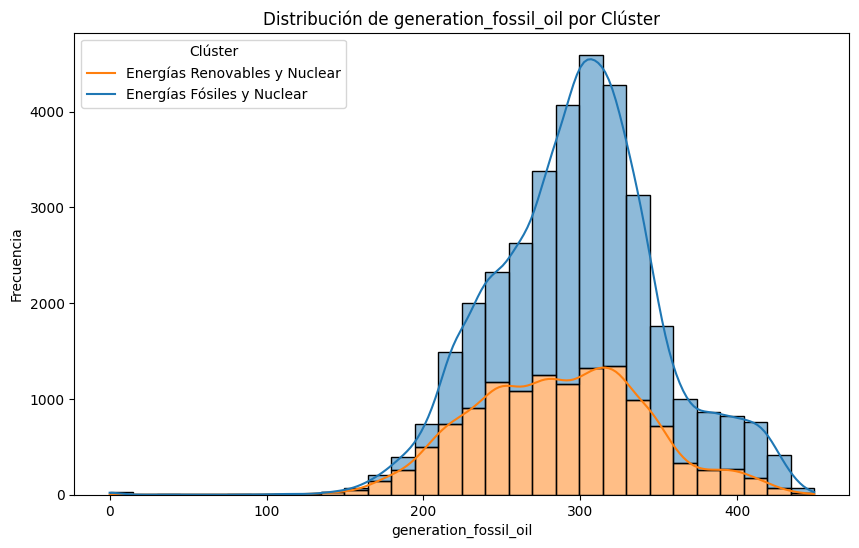

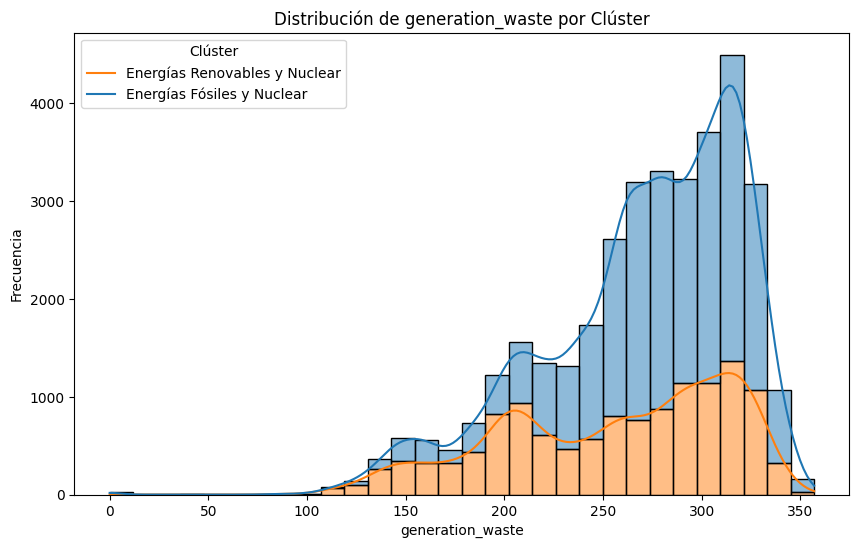

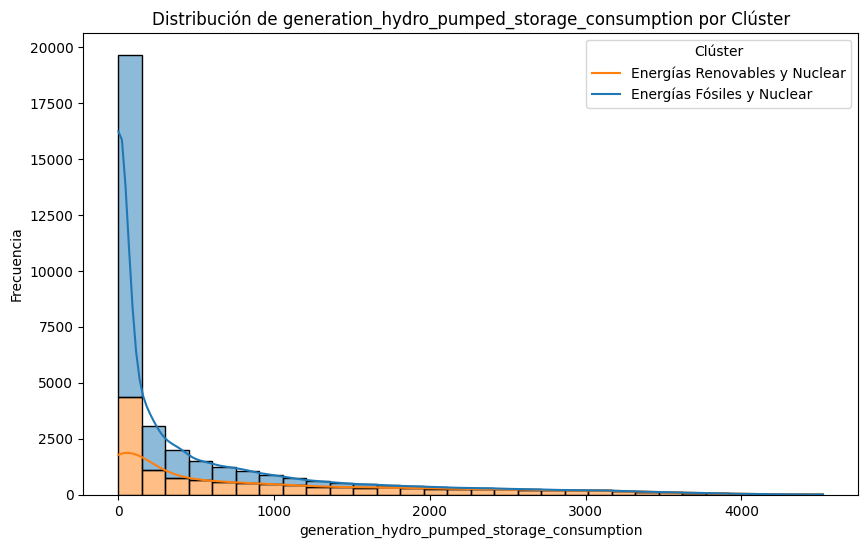

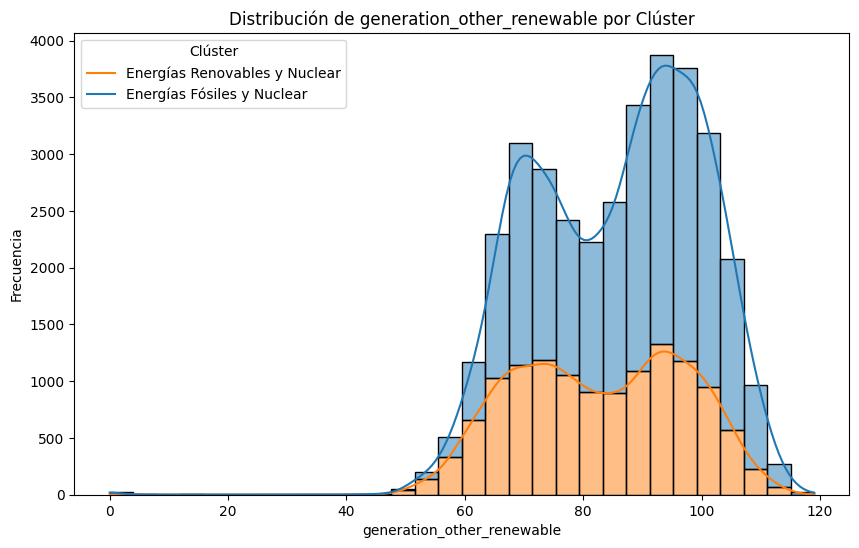

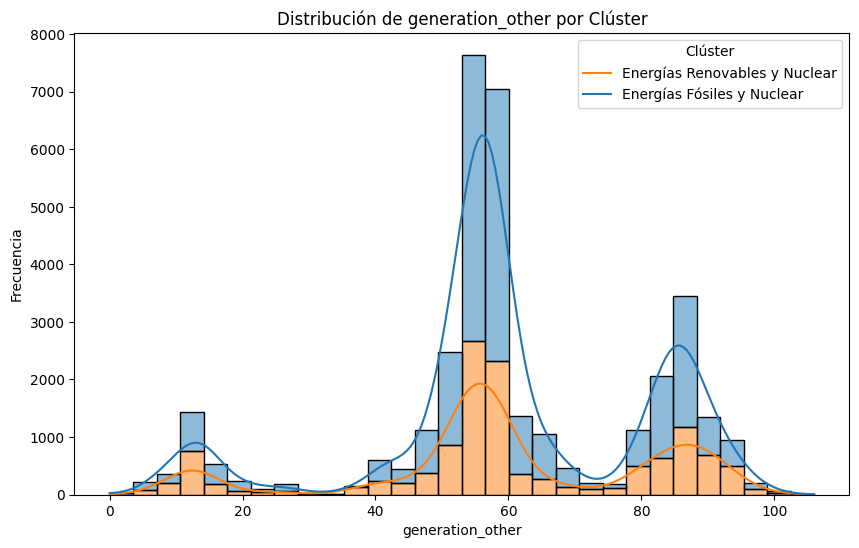

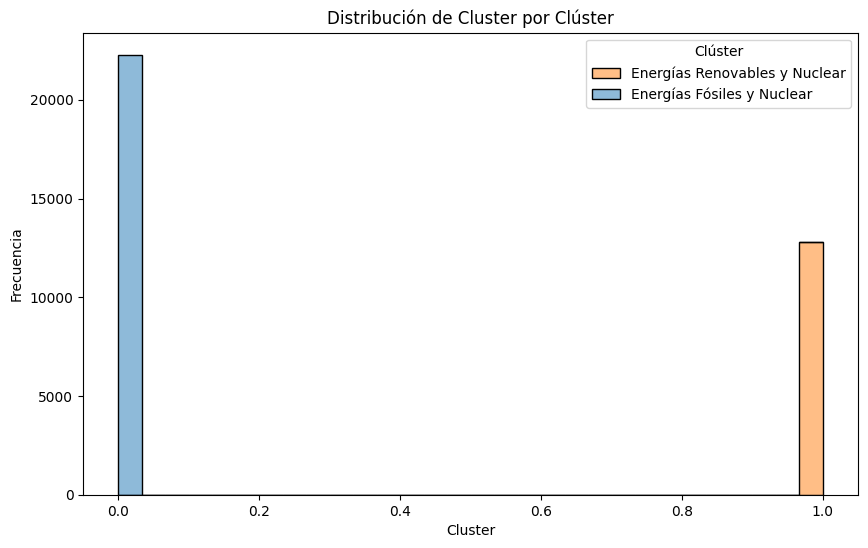

In [74]:
# Histograma variables agrupando los clusters
df_clusters_hist = df_clusters.transpose()
for feature in df_clusters_hist.columns:
    plt.figure(figsize=(10, 6))

    # Dibujar el histograma de 'total_load_actual' coloreado por clúster
    sns.histplot(data=x_kmeans, x=feature, hue='Cluster', multiple='stack', bins=30, kde=True)

    # Títulos y etiquetas
    plt.title(f'Distribución de {feature} por Clúster')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')
    plt.legend(title='Clúster', labels=['Energías Renovables y Nuclear', 'Energías Fósiles y Nuclear' ])
    plt.show()

**Análisis del consumo frente a otras variables**

In [114]:
# variables relacionadas con la fecha
years= df_copy['time_hourly'].dt.year
months = df_copy['time_hourly'].dt.month
diarys = df_copy['time_hourly'].dt.day
hourly = df_copy['time_hourly'].dt.hour

Text(0.5, 1.0, 'Demanda energética anual')

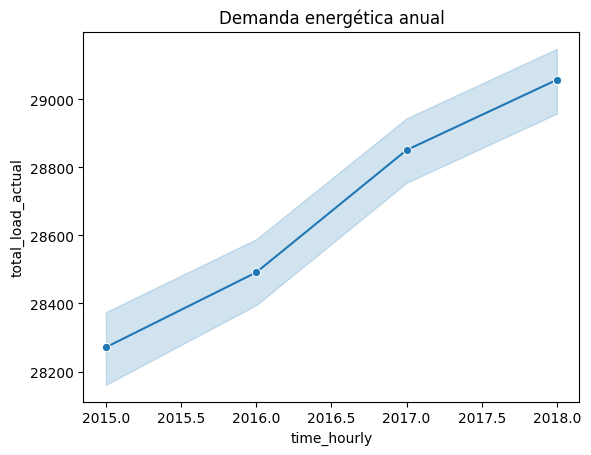

In [107]:
sns.lineplot(data=df_copy, x=years, y='total_load_actual',marker='o')
plt.title('Demanda energética anual')

La demanda energética a lo largo de los años ha ido aumentando

Text(0.5, 1.0, 'Demanda energética mensual')

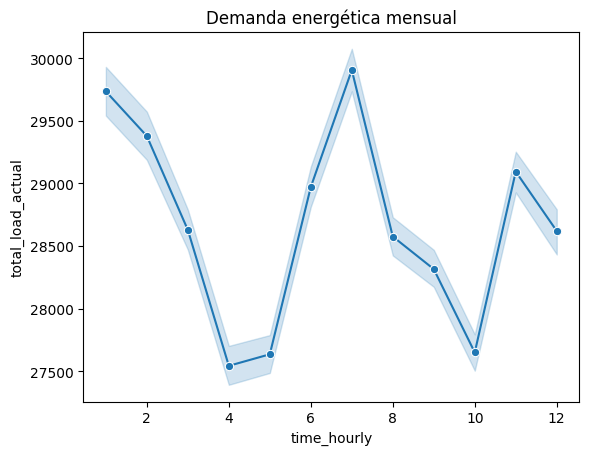

In [113]:
sns.lineplot(data=df_copy, x=months, y='total_load_actual', marker='o')
plt.title('Demanda energética mensual')

Podemos observar meses de demanda alta y otros con demanda baja:

- Demanda alta: Enero, Febrero, Julio.
- Demanda media: Marzo, Junio, Agosto, Septiembre, Noviembre, Diciembre.
- Demanda Baja: Abril, Mayo, Octubre.

Text(0.5, 1.0, 'Demanda energética diaria')

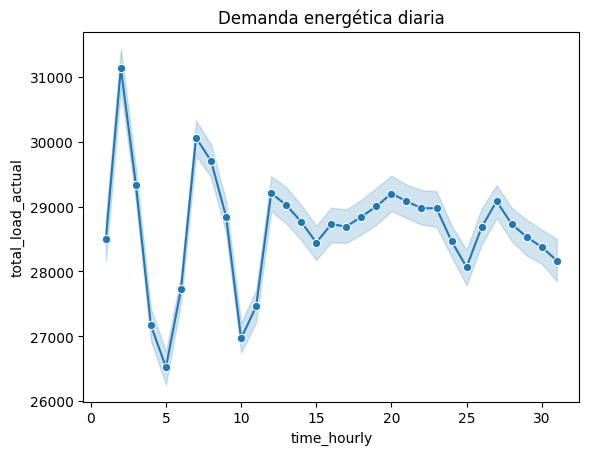

In [112]:
sns.lineplot(data=df_copy, x=diarys, y='total_load_actual', marker='o')
plt.title('Demanda energética diaria')

Observamos como la demanda tiende a ser mas inestable (con picos y bajadas) en la primera quincena de cada mes.
Posteriormente en la segunda quincena se estabiliza manteniendose similar.

Text(0.5, 1.0, 'Demanda energética por horas')

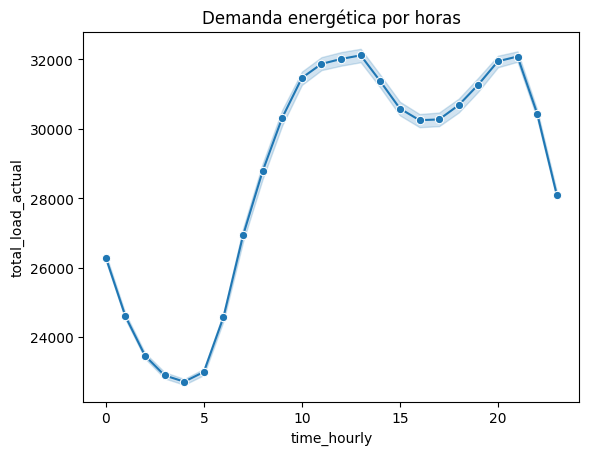

In [119]:
sns.lineplot(data=df_copy, x=hourly, y='total_load_actual', marker='o')
plt.title('Demanda energética por horas')

- La demanda energética baja sobretodo a partir de las 20:00 hasta las 5:00 de la mañana.
- El pico se da en torno las 10:00 de la mañana y 20:00 de la tarde (bajando posteriormente).

**Análisis del precio de la energía**

Text(0.5, 1.0, 'Precio energía mensualmente')

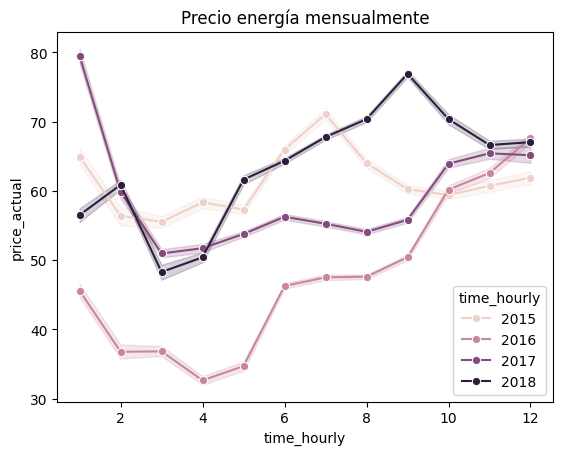

In [123]:
sns.lineplot(data=df_copy, x=months, y='price_actual', marker='o', hue=years)
plt.title('Precio energía mensualmente')

En general los precios bajan desde Enero hasta Abril, subiendo nuevamente.

- En 2015, el precio en Enero rondaba los 65€, subiendo hasta un maximo de 70€ (Julio), acabando el año con un precio de 62€.
- En 2016, el precio en Enero rondaba los 46€, acabando el año con un precio de 67€.
- En 2017, el precio en Enero rondaba los 80€, con una caida previa hasta los 52€, acabando el año con un precio de 64€.
- En 2018, el precio en Enero rondaba los 58€, con una caida previa hasta los 49€, acabando el año con un precio de 65€.

El precio de la energía anualmente ha ido subiendo respectivamente.

Text(0.5, 1.0, 'Precio energía por horas')

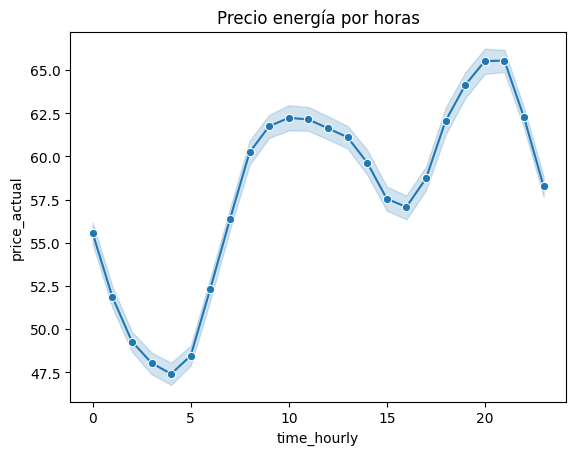

In [124]:
sns.lineplot(data=df_copy, x=hourly, y='price_actual', marker='o')
plt.title('Precio energía por horas')

El gráfico muestra una relacion parecida al de la demanda.
En horario nocturno el precio baja, aumentando a partir de las 5 de la mañana.

**Análisis de clusteres con respecto a la demanda y el precio de la energía**

In [8]:
# Añadimos valores del cluster al dataframe
clusters = x_kmeans[['Cluster']]
df_copy['Cluster'] = clusters

Text(0.5, 1.0, 'Demanda energético por grupos')

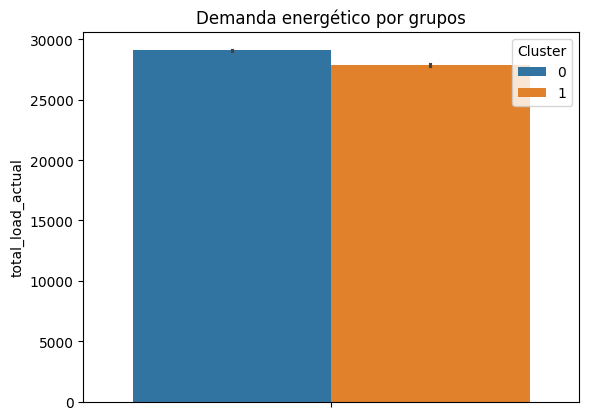

In [15]:
sns.barplot(data=df_copy, y='total_load_actual', hue='Cluster')
plt.title('Demanda energético por grupos')

Podemos observar una demanda bastante similar tanto en el grupo de nergías fósiles como renovables.
Siendo ligeramente mayor la demanda en el grupo de energías fósiles.

Text(0.5, 1.0, 'Precio energético por grupos')

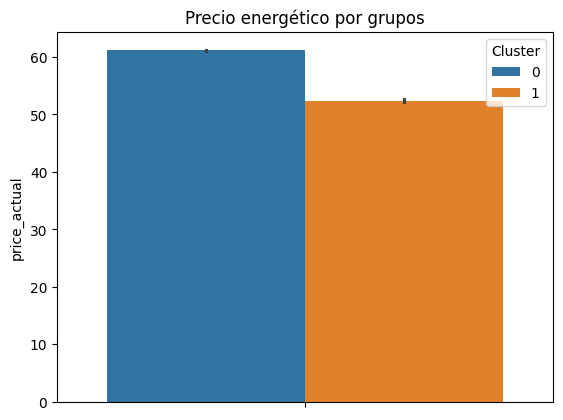

In [16]:
sns.barplot(data=df_copy, y='price_actual', hue='Cluster')
plt.title('Precio energético por grupos')

Observamos un mayor incremento del precio en el grupo de las energías fósiles, aún que no se manifiesta diferencias significativas 
entre ambos grupos.